<a href="https://colab.research.google.com/github/blessjal/practicums/blob/master/breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

%matplotlib inline
plt.style.use('ggplot')

In [49]:
df = pd.read_csv('/content/sample_data/breast-cancer.data')

df.head()

,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no.1
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [50]:
 
columns = [ 'Class', 'age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
df.columns = columns
df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
3,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,left,left_low,no


In [51]:
df.dtypes

Class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        285 non-null    object
 1   age          285 non-null    object
 2   menopause    285 non-null    object
 3   tumor-size   285 non-null    object
 4   inv-nodes    285 non-null    object
 5   node-caps    285 non-null    object
 6   deg-malig    285 non-null    int64 
 7   breast       285 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     285 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.4+ KB


In [61]:
X = df.drop('Class', axis=1)
y = df['Class']

X.shape, y.shape

((285, 9), (285,))

In [6]:

for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has '{unique_cat}' unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'age' has '6' unique categories
Feature 'menopause' has '3' unique categories
Feature 'tumor-size' has '11' unique categories
Feature 'inv-nodes' has '7' unique categories
Feature 'node-caps' has '3' unique categories
Feature 'breast' has '2' unique categories
Feature 'breast-quad' has '6' unique categories
Feature 'irradiat' has '2' unique categories


In [7]:
todummy_list = ['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat', 'age', 'tumor-size', 'inv-nodes']
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis=1)
        df = pd. concat([df, dummies], axis=1)
    return df

In [8]:
X = dummy_df(X, todummy_list)



In [9]:
X.isnull().sum().sort_values(ascending=False).head()

inv-nodes_9-11    0
age_40-49         0
age_20-29         0
irradiat_yes      0
irradiat_no       0
dtype: int64

In [10]:
def plot_histogram(x):
    plt.hist(x, color = 'blue', alpha=0.5)
    plt.title("Histogram of {var_name}".format(var_name=x.name))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

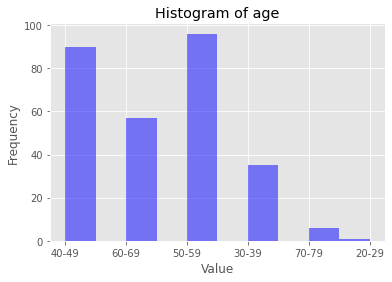

In [11]:
plot_histogram(df['age'])

## Check for Interactions and Remove significant Interactions

In [12]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

In [13]:
def add_interactions(df):
    #get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    #find interactions
    poly = PolynomialFeatures(interaction_only = True, include_bias = False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    #remove interaction terms with all 0 values
    noint_indices = [i for i, x in enumerate(list((df == 0).all()))if x]
    df = df.drop(df.columns[noint_indices], axis=1)
    
    return df

In [14]:
X = add_interactions(X)
X.head()

,deg-malig,menopause_ge40,menopause_lt40,menopause_premeno,node-caps_?,node-caps_no,node-caps_yes,breast_left,breast_right,breast-quad_?,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,tumor-size_0-4,tumor-size_10-14,tumor-size_15-19,tumor-size_20-24,tumor-size_25-29,tumor-size_30-34,tumor-size_35-39,tumor-size_40-44,tumor-size_45-49,tumor-size_5-9,tumor-size_50-54,inv-nodes_0-2,inv-nodes_12-14,inv-nodes_15-17,inv-nodes_24-26,inv-nodes_3-5,inv-nodes_6-8,...,age_70-79_inv-nodes_0-2,age_70-79_inv-nodes_9-11,tumor-size_0-4_inv-nodes_0-2,tumor-size_10-14_inv-nodes_0-2,tumor-size_10-14_inv-nodes_3-5,tumor-size_10-14_inv-nodes_6-8,tumor-size_15-19_inv-nodes_0-2,tumor-size_15-19_inv-nodes_12-14,tumor-size_15-19_inv-nodes_15-17,tumor-size_15-19_inv-nodes_6-8,tumor-size_15-19_inv-nodes_9-11,tumor-size_20-24_inv-nodes_0-2,tumor-size_20-24_inv-nodes_24-26,tumor-size_20-24_inv-nodes_3-5,tumor-size_20-24_inv-nodes_6-8,tumor-size_25-29_inv-nodes_0-2,tumor-size_25-29_inv-nodes_12-14,tumor-size_25-29_inv-nodes_15-17,tumor-size_25-29_inv-nodes_3-5,tumor-size_25-29_inv-nodes_6-8,tumor-size_25-29_inv-nodes_9-11,tumor-size_30-34_inv-nodes_0-2,tumor-size_30-34_inv-nodes_12-14,tumor-size_30-34_inv-nodes_15-17,tumor-size_30-34_inv-nodes_3-5,tumor-size_30-34_inv-nodes_6-8,tumor-size_30-34_inv-nodes_9-11,tumor-size_35-39_inv-nodes_0-2,tumor-size_35-39_inv-nodes_15-17,tumor-size_35-39_inv-nodes_6-8,tumor-size_35-39_inv-nodes_9-11,tumor-size_40-44_inv-nodes_0-2,tumor-size_40-44_inv-nodes_15-17,tumor-size_40-44_inv-nodes_3-5,tumor-size_40-44_inv-nodes_6-8,tumor-size_45-49_inv-nodes_0-2,tumor-size_45-49_inv-nodes_6-8,tumor-size_5-9_inv-nodes_0-2,tumor-size_50-54_inv-nodes_0-2,tumor-size_50-54_inv-nodes_9-11
0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality Reduction using PCA

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

X_pca = pd.DataFrame(pca.fit_transform(X))

X_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,2.974624,-2.806047,0.417706,-0.163285,-0.736878,1.315985,-1.025779,-0.508631,1.421525,-0.163642
1,1.269802,-1.211792,-3.868729,-0.533597,0.562373,1.544172,-0.836109,-1.909353,1.700404,0.336482
2,-2.034261,-2.194094,3.488823,-1.201067,1.227062,0.210017,-0.720975,-0.226264,-1.635230,0.276495
3,2.885793,-2.552770,0.094699,-0.509133,-0.513037,0.432341,-0.606064,0.530707,0.297800,-1.066586
4,-3.627114,-0.203887,-1.492604,-2.526401,0.745246,1.172639,-0.744222,-0.002274,-1.188180,0.224627


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199, 564), (86, 564), (199,), (86,))

In [17]:
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  9  17  37  49  57  77  86 112 122 126 127 144 156 175 176 185 193 207
 241 245 272 283 297 306 307 308 309 311 326 334 343 348 386 390 393 399
 406 410 414 440 448 454 458 459 468 481 516 521 525 532 534 536 538 544
 559] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [18]:
colnames_selected

['deg-malig',
 'node-caps_no',
 'node-caps_yes',
 'inv-nodes_0-2',
 'deg-malig_node-caps_yes',
 'deg-malig_breast_left',
 'deg-malig_irradiat_yes',
 'deg-malig_age_30-39',
 'menopause_ge40_inv-nodes_0-2',
 'menopause_premeno_node-caps_yes',
 'node-caps_no_irradiat_no',
 'node-caps_no_inv-nodes_0-2',
 'node-caps_yes_breast_left',
 'node-caps_yes_breast-quad_left_low',
 'breast_left_irradiat_yes',
 'breast_left_age_30-39',
 'breast_left_inv-nodes_6-8',
 'breast-quad_left_low_inv-nodes_6-8',
 'irradiat_no_inv-nodes_0-2',
 'irradiat_yes_inv-nodes_6-8']

## Logistic Regression Model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def find_model_perf(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    
    return auc

In [20]:
auc_processed = find_model_perf(X_train_selected, X_test_selected, y_train, y_test)
auc_processed

0.6698717948717948

In [90]:
lr = LogisticRegression()
lr.fit(X_train_selected, y_train)

lr_pred = lr.predict(X_test_selected)

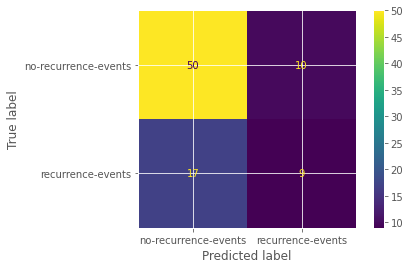

In [91]:
plot_confusion_matrix(lr, X_test_selected,y_test)

In [92]:
print(classification_report(y_test, lr_pred))

                      precision    recall  f1-score   support

no-recurrence-events       0.75      0.83      0.79        60
   recurrence-events       0.47      0.35      0.40        26

            accuracy                           0.69        86
           macro avg       0.61      0.59      0.59        86
        weighted avg       0.66      0.69      0.67        86



In [93]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(lr, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.7342105263157894


In [104]:
LogisticRegression()
# define grid
grid = {'penalty': ['I1', 'I2', 'elasticnet', 'none'], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'multi_class': ['auto', 'ovr', 'multinomial'], 'max_iter': [100, 200, 300]}

# define search
search = GridSearchCV(lr, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
lr_results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % lr_results.best_score_)
print('The best parameters of the logistic regression model: %s' % lr_results.best_params_)

Mean Accuracy: 0.716
The best parameters of the model: {'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'sag'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [105]:
print('The best estimator of the logistic regression model: ', lr_results.best_estimator_)
print()
print('-'*100)
print('The best index of the logistic regression model: ', lr_results.best_index_)
print()
print('-'*100)
print('The best parameter of the logistic regression. model: ', lr_results.best_params_)
print()
print('-'*100)
print('The best score of the logistic regression model: ', lr_results.best_score_)

The best estimator of the logistic regression model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

----------------------------------------------------------------------------------------------------
The best index of the logistic regression model:  18

----------------------------------------------------------------------------------------------------
The best parameter of the logistic regression. model:  {'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'sag'}

----------------------------------------------------------------------------------------------------
The best score of the logistic regression model:  0.7158771929824561


## Random Forest Model

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

def rf_model(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = [x[1] for x in rf.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_pred)
    return auc
  


In [87]:
rf_model(X_train_selected, X_test_selected, y_train, y_test)

0.6442307692307692

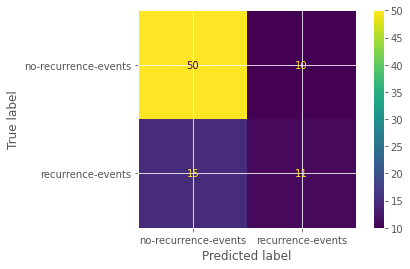

In [88]:
rf=RandomForestClassifier()
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X_test_selected)
plot_confusion_matrix(rf, X_test_selected, y_test)


In [89]:
print(classification_report(y_test, rf_pred))

                      precision    recall  f1-score   support

no-recurrence-events       0.77      0.83      0.80        60
   recurrence-events       0.52      0.42      0.47        26

            accuracy                           0.71        86
           macro avg       0.65      0.63      0.63        86
        weighted avg       0.70      0.71      0.70        86



In [26]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(rf, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6871929824561404


In [27]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [106]:
from sklearn.model_selection import GridSearchCV
RandomForestClassifier()
# define grid
grid = {'n_estimators': [100, 200], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [int, None], 'bootstrap': [True, False] }

# define search
search = GridSearchCV(rf, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
rf_results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % rf_results.best_score_)
print('The best parameters of the random forest model: %s' % rf_results.best_params_)

Mean Accuracy: 0.694
The best parameters of the random forest model: {'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes': None, 'n_estimators': 100}


In [107]:
print('The best estimator of the random forest model: ', rf_results.best_estimator_)
print()
print('-'*100)
print('The best index of the random forest model: ', rf_results.best_index_)
print()
print('-'*100)
print('The best parameter of the random forest model: ', rf_results.best_params_)
print()
print('-'*100)
print('The best score of the random forest model: ', rf_results.best_score_)


The best estimator of the random forest model:  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

----------------------------------------------------------------------------------------------------
The best index of the random forest model:  14

----------------------------------------------------------------------------------------------------
The best parameter of the random forest model:  {'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes': None, 'n_estimators': 100}

-----------

## Decision Tree Model

In [30]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_selected, y_train)
dt_pred = dt.predict(X_test_selected)

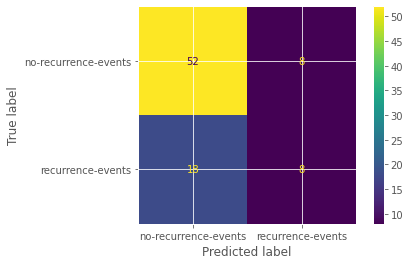

In [31]:
plot_confusion_matrix(dt, X_test_selected, y_test)

In [32]:
print(classification_report(y_test, dt_pred))

                      precision    recall  f1-score   support

no-recurrence-events       0.74      0.87      0.80        60
   recurrence-events       0.50      0.31      0.38        26

            accuracy                           0.70        86
           macro avg       0.62      0.59      0.59        86
        weighted avg       0.67      0.70      0.67        86



In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(dt, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6821929824561402


In [108]:
DecisionTreeClassifier()
# define grid
grid = {'splitter': ['random', 'best'], 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [int, None], 'max_features': ['auto', 'sqrt', 'log2']}

# define search
search = GridSearchCV(dt, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
dt_results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % dt_results.best_score_)
print('The best parameters of the decision tree model: %s' % dt_results.best_params_)

Mean Accuracy: 0.709
The best parameters of the decision tree model: {'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': None, 'splitter': 'random'}


In [109]:
print('The best estimator of the decision tree model: ', dt_results.best_estimator_)
print()
print('-'*100)
print('The best index of the decision tree model: ', dt_results.best_index_)
print()
print('-'*100)
print('The best parameter of the decision tree model: ', dt_results.best_params_)
print()
print('-'*100)
print('The best score of the decision tree model: ', dt_results.best_score_)

The best estimator of the decision tree model:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

----------------------------------------------------------------------------------------------------
The best index of the decision tree model:  2

----------------------------------------------------------------------------------------------------
The best parameter of the decision tree model:  {'criterion': 'gini', 'max_features': 'auto', 'max_leaf_nodes': None, 'splitter': 'random'}

----------------------------------------------------------------------------------------------------
The best score of the decisio

## Naive Bayes Model

In [37]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_selected, y_train)
gnb_pred = gnb.predict(X_test_selected)

In [38]:

#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(gnb, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.7359649122807017


In [111]:

# define grid
grid = {'priors': [None], 'var_smoothing': [1e-09]}

# define search
search = GridSearchCV(gnb, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
gnb_results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % gnb_results.best_score_)
print('The best parameters of the naive bayes model: %s' % gnb_results.best_params_)

Mean Accuracy: 0.736
The best parameters of the naive bayes model: {'priors': None, 'var_smoothing': 1e-09}


<bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=1e-09)>

In [112]:
print('The best estimator of the naive bayes model: ', gnb_results.best_estimator_)
print()
print('-'*100)
print('The best index of the naive bayes model: ', gnb_results.best_index_)
print()
print('-'*100)
print('The best parameter of the naive bayes model: ', gnb_results.best_params_)
print()
print('-'*100)
print('The best score of the naive bayes model: ', gnb_results.best_score_)

The best estimator of the naive bayes model:  GaussianNB(priors=None, var_smoothing=1e-09)

----------------------------------------------------------------------------------------------------
The best index of the naive bayes model:  0

----------------------------------------------------------------------------------------------------
The best parameter of the naive bayes model:  {'priors': None, 'var_smoothing': 1e-09}

----------------------------------------------------------------------------------------------------
The best score of the naive bayes model:  0.7359649122807017


## K Nearest Neighbors

In [62]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_train)

knn_pred = knn.predict(X_test_selected)

In [63]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(knn, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  



0.7223684210526315


In [64]:
knn.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')>

In [113]:
# define grid
grid = {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [30, 40, 50], 'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']}

# define search
search = GridSearchCV(knn, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
knn_results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % knn_results.best_score_)

Mean Accuracy: 0.754


In [114]:
print('The best estimator of the KNN model: ', knn_results.best_estimator_)
print()
print('-'*100)
print('The best index of the KNN model: ', knn_results.best_index_)
print()
print('-'*100)
print('The best parameter of the KNN model: ', knn_results.best_params_)
print()
print('-'*100)
print('The best score of the KNN model: ', knn_results.best_score_)

The best estimator of the KNN model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

----------------------------------------------------------------------------------------------------
The best index of the KNN model:  2

----------------------------------------------------------------------------------------------------
The best parameter of the KNN model:  {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 10, 'weights': 'uniform'}

----------------------------------------------------------------------------------------------------
The best score of the KNN model:  0.7542982456140351


## Linear Discriminant Analysis

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda.fit(X_train_selected, y_train)

lda_pred = lda.predict(X_test_selected)

In [74]:
#Define method to evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(lda, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  



0.707280701754386


In [ ]:
LDA()

In [115]:
# define grid
grid = {'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': np.arange(0, 1, 0.01), 'n_components': [0, 1, 2] }

# define search
search = GridSearchCV(lda, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
lda_results = search.fit(X_train_selected, y_train)

# summarize
print('Mean Accuracy: %.3f' % lda_results.best_score_)

Mean Accuracy: 0.741


In [116]:
print('The best estimator of the LDA model: ', lda_results.best_estimator_)
print()
print('-'*100)
print('The best index of the LDA model: ', lda_results.best_index_)
print()
print('-'*100)
print('The best parameter of the LDA model: ', lda_results.best_params_)
print()
print('-'*100)
print('The best score of the LDA model: ', lda_results.best_score_)

The best estimator of the LDA model:  LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=0.29,
                           solver='lsqr', store_covariance=False, tol=0.0001)

----------------------------------------------------------------------------------------------------
The best index of the LDA model:  88

----------------------------------------------------------------------------------------------------
The best parameter of the LDA model:  {'n_components': 0, 'shrinkage': 0.29, 'solver': 'lsqr'}

----------------------------------------------------------------------------------------------------
The best score of the LDA model:  0.7407894736842106


## Quadratic Discriminant Analysis

In [77]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [79]:
qda = QDA()
qda.fit(X_train_selected, y_train)
qda_pred = qda.predict(X_test_selected)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [80]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(qda, X_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))  

0.6162280701754386


In [81]:
grid = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# define search
qda_search = GridSearchCV(qda, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# fit the search
qda_results = qda_search.fit(X_train, y_train)

# summarize
print('Mean Accuracy: %.3f' % qda_results.best_score_)
print('The best parameters of the model: %s' % qda_results.best_params_)

Mean Accuracy: 0.747
The best parameters of the model: {'reg_param': 0.01, 'store_covariance': True, 'tol': 0.0001}


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [82]:
print('The best estimator of the model: ', qda_results.best_estimator_)
print()
print('-'*100)
print('The best index of the model: ', qda_results.best_index_)
print()
print('-'*100)
print('The best parameter of the model: ', qda_results.best_params_)
print()
print('-'*100)
print('The best score of the model: ', qda_results.best_score_)


The best estimator of the model:  QuadraticDiscriminantAnalysis(priors=None, reg_param=0.01,
                              store_covariance=True, tol=0.0001)

----------------------------------------------------------------------------------------------------
The best index of the model:  24

----------------------------------------------------------------------------------------------------
The best parameter of the model:  {'reg_param': 0.01, 'store_covariance': True, 'tol': 0.0001}

----------------------------------------------------------------------------------------------------
The best score of the model:  0.7471052631578947


## Compare Models

In [121]:
models = {'model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'Gaussian Naive Bayes', 'K Nearest Neighbors', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis'],
          'best_scores': [lr_results.best_score_, rf_results.best_score_, dt_results.best_score_, gnb_results.best_score_, knn_results.best_score_, lda_results.best_score_, qda_results.best_score_]}

compare_models = pd.DataFrame(models)
compare_models

,model,best_scores
0,Logistic Regression,0.715877
1,Random Forest,0.694035
2,Decision Tree,0.708947
3,Gaussian Naive Bayes,0.735965
4,K Nearest Neighbor,0.754298
5,Linear Discriminant Analysis,0.740789
6,Quadratic Discriminant Analysis,0.747105


In [122]:
compare_models.sort_values('best_scores', ascending=False)

,model,best_scores
4,K Nearest Neighbor,0.754298
6,Quadratic Discriminant Analysis,0.747105
5,Linear Discriminant Analysis,0.740789
3,Gaussian Naive Bayes,0.735965
0,Logistic Regression,0.715877
2,Decision Tree,0.708947
1,Random Forest,0.694035
